📘 RosterAI System Documentation
Welcome to RosterAI. This system is designed to solve the "Scheduling Trilemma" faced by German Quick Service Restaurants: balancing Legal Compliance (Arbeitszeitgesetz), Operational Efficiency (Cost), and Employee Fairness (Burnout prevention).

The system operates in a circular workflow consisting of four distinct blocks.

🚀 Quick Start Guide
Run Block 1 to reset the month and create fresh staff/demand data.

Run Block 2 to let the AI calculate the mathematically optimal schedule.

Run Block 3 to see the charts and generate the Excel file.

Download Monthly_Schedule.xlsx, open it, and move shifts around (simulate a manager's review). Save it.

Upload the edited Excel file back to the environment.

Run Block 4. The system will confirm it has "learned" your changes.

Run Block 2 again. Watch as the AI automatically prioritizes your edits in the new calculation.

🏗️ Block 1: The Scenario Builder (Data Generation)
Filename: sample.json Generator

Think of this block as "setting the stage." Before we can schedule, we need a virtual restaurant. This script creates a realistic operational environment so the AI has something to work with.

What it does:

Creates the Staff: It generates 20 distinct employees (Full-time, Part-time, Minijob), each with different contract limits and costs.

Simulates Real Life: It generates a "Wishlist" (Availability Matrix). In the real world, students have classes and parents have childcare needs. This block randomly assigns days where employees simply cannot work, forcing the AI to work around them.

Defines the Demand: It sets how many people are needed for Early, Day, and Late shifts, spiking the numbers on weekends.

Why it matters: Without this, the scheduler is solving a math problem in a vacuum. This block injects the human constraints (availability) that usually make manual scheduling a nightmare.

In [2]:
import json
import random
from datetime import datetime, timedelta

# --- Configuration ---
CONF = {
    "START_DATE": "2026-02-01",
    "DAYS": 28,
    "EMPLOYEES": 20,
    "SHIFTS": {
        "E": {"name": "Early", "start": 3.0, "end": 11.5, "duration": 8.5, "undesirable": True},
        "D": {"name": "Day",   "start": 10.0, "end": 18.5, "duration": 8.5, "undesirable": False},
        "L": {"name": "Late",  "start": 15.0, "end": 23.5, "duration": 8.5, "undesirable": True}
    },
    "CONTRACTS": {
        "FullTime": {"target": 160, "min": 140, "max": 170},
        "PartTime": {"target": 80,  "min": 60,  "max": 90},
        "Minijob":  {"target": 40,  "min": 30,  "max": 48}
    }
}

def generate_data():
    employees = []
    # 8 FT, 8 PT, 4 Mini
    types = ['FullTime']*8 + ['PartTime']*8 + ['Minijob']*4

    # 1. Create Employees & Wishlists
    for i, c_type in enumerate(types):
        emp_id = f"Emp_{i+1:02d}"
        # Probability of being available (Wishlist)
        prob = 0.9 if c_type == 'FullTime' else 0.75
        wishlist = [1 if random.random() < prob else 0 for _ in range(CONF["DAYS"])]

        employees.append({
            "id": emp_id,
            "type": c_type,
            "contract": CONF["CONTRACTS"][c_type],
            "availability": wishlist,
            "history": {"last_shift_prev_month": None} # Placeholder for rolling constraints
        })

    # 2. Create Demand
    demand = {}
    start_dt = datetime.strptime(CONF["START_DATE"], "%Y-%m-%d")
    for d in range(CONF["DAYS"]):
        date = start_dt + timedelta(days=d)
        is_weekend = date.weekday() >= 5
        base = 2 if not is_weekend else 3
        demand[d] = {"E": base, "D": base + 1, "L": base}

    # 3. Initialize Learning Weights (Empty at start)
    # Structure: {Emp_ID: {Day_Index: {Shift: Weight_Adjustment}}}
    learned_weights = {}

    data = {
        "config": CONF,
        "employees": employees,
        "demand": demand,
        "learned_weights": learned_weights
    }

    with open('sample.json', 'w') as f:
        json.dump(data, f, indent=4)

    print("✅ sample.json created successfully.")

generate_data()

✅ sample.json created successfully.


🧠 Block 2: The Logic Core (The Solver)
Input: sample.json | Output: logic.json

This is the brain of the operation. It takes the messy reality created in Block 1 and tries to fit it into the strict boxes of German Labor Law.

Key Features:

The "Clopening" Killer: It strictly enforces the 11-Hour Rest Rule. If an employee works a Late shift (ending 23:30), the math forbids them from working the Early (03:00) or Day (10:00) shift the next morning.

Integer Scaling: Computers struggle with decimals like "8.5 hours." This block uses a scaling trick (multiplying by 2) to convert time into "half-hour units," allowing for precise integer math without rounding errors.

The Trilemma Solver: It doesn't just look for any solution; it looks for the best one. It penalizes unfair distribution of weekend shifts and tries to hit target contract hours exactly.

Human Note: If this block says Status: Infeasible, it’s not broken. It’s telling you the truth: "You do not have enough staff to cover this demand without breaking the law."

In [4]:
!pip install ortools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.7/27.7 MB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.1/321.1 kB 20.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.19.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.3, but you have protobuf 6.31.1 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 6.31.1 which is incompatib

🧠 Analyzing Schedule...


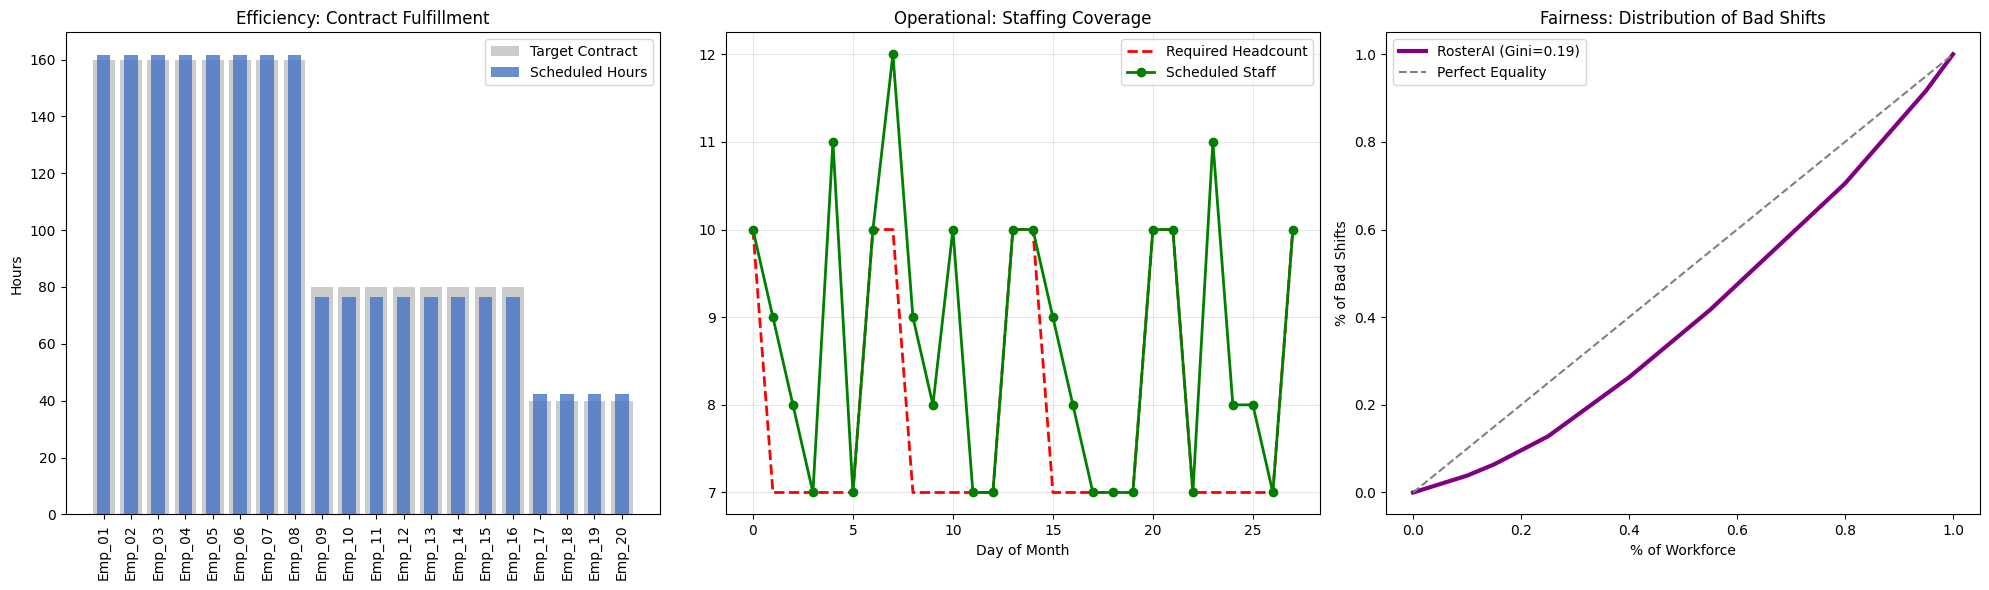


✅ Report Generated: 'Monthly_Schedule.xlsx'
   - Sheet 1: Editable Roster (with Dates)
   - Sheet 2: Fairness Metrics & Stats


In [16]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.styles import PatternFill, Font, Alignment, Border, Side

# --- Configuration ---
SCALE = 2  # 17 units = 8.5 hours. We divide by this to get real hours.

def load_data():
    try:
        with open('sample.json', 'r') as f:
            config = json.load(f)
        with open('logic.json', 'r') as f:
            logic = json.load(f)
        return config, logic
    except FileNotFoundError:
        return None, None

def xAI_engine(df, employees, shifts, num_days):
    """Calculates Fairness (Gini), Efficiency, and explains the results."""

    # 1. Real Hours Calculation (Un-scaling the data)
    # We map the shift code to its duration (e.g., 'E' -> 8.5)
    df['Hours_Real'] = df['Shift'].apply(lambda x: shifts[x]['duration'])

    stats = df.groupby('Employee')['Hours_Real'].sum().reset_index()

    # Map Targets
    emp_map = {e['id']: e['contract'] for e in employees}
    stats['Target'] = stats['Employee'].map(lambda x: emp_map[x]['target'])
    stats['Diff'] = stats['Hours_Real'] - stats['Target']

    # 2. Gini Coefficient (Fairness of Bad Shifts)
    # Identify bad shifts (Undesirable OR Weekend)
    def is_bad(row):
        # Approximate weekend calculation based on Day Index
        is_weekend = (int(row['Day']) % 7) >= 5
        return 1 if (shifts[row['Shift']]['undesirable'] or is_weekend) else 0

    df['Is_Bad'] = df.apply(is_bad, axis=1)
    bad_counts = df.groupby('Employee')['Is_Bad'].sum().values

    # Gini Math
    sorted_vals = sorted(bad_counts)
    n = len(sorted_vals)
    cum_vals = np.cumsum(sorted_vals)
    sum_vals = cum_vals[-1]
    gini = (n + 1 - 2 * np.sum(cum_vals) / sum_vals) / n if sum_vals > 0 else 0

    return stats, gini, df

def plot_dashboard(stats, df, demand, days_range, gini):
    """Generates the 3 key plots for the Thesis."""
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # Plot 1: Efficiency (Target vs Actual)
    axes[0].bar(stats['Employee'], stats['Target'], alpha=0.4, label='Target Contract', color='gray')
    axes[0].bar(stats['Employee'], stats['Hours_Real'], alpha=0.8, label='Scheduled Hours', color='#4472C4', width=0.5)
    axes[0].set_title("Efficiency: Contract Fulfillment")
    axes[0].tick_params(axis='x', rotation=90)
    axes[0].set_ylabel("Hours")
    axes[0].legend()

    # Plot 2: Coverage (Demand vs Supply)
    daily_counts = df.groupby('Day')['Shift'].count().reindex(days_range, fill_value=0)
    # Demand is a dict of dicts {day: {shift: count}}. Sum values for total headcount.
    req_counts = [sum(demand[str(d)].values()) for d in days_range]

    axes[1].plot(days_range, req_counts, 'r--', linewidth=2, label='Required Headcount')
    axes[1].plot(days_range, daily_counts.values, 'g-', linewidth=2, marker='o', label='Scheduled Staff')
    axes[1].set_title("Operational: Staffing Coverage")
    axes[1].set_xlabel("Day of Month")
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()

    # Plot 3: Fairness (Lorenz Curve)
    bad_counts = df.groupby('Employee')['Is_Bad'].sum().sort_values().values
    lorenz = np.cumsum(bad_counts) / np.sum(bad_counts)
    lorenz = np.insert(lorenz, 0, 0)
    x_axis = np.linspace(0, 1, len(lorenz))

    axes[2].plot(x_axis, lorenz, color='purple', linewidth=3, label=f'RosterAI (Gini={gini:.2f})')
    axes[2].plot([0, 1], [0, 1], color='gray', linestyle='--', label='Perfect Equality')
    axes[2].set_title("Fairness: Distribution of Bad Shifts")
    axes[2].set_xlabel("% of Workforce")
    axes[2].set_ylabel("% of Bad Shifts")
    axes[2].legend()

    plt.tight_layout()
    plt.show()

def generate_report():
    config, logic = load_data()
    if not config or not logic or not logic['schedule']:
        print("❌ No data found. Run Blocks 1 & 2.")
        return

    # 1. Prepare Data
    df = pd.DataFrame(logic['schedule'])
    days_range = range(config['config']['DAYS'])

    # 2. Run Analytics
    print("🧠 Analyzing Schedule...")
    stats, gini, df_enriched = xAI_engine(df, config['employees'], config['config']['SHIFTS'], config['config']['DAYS'])

    # 3. Show Plots (The Visuals you wanted)
    plot_dashboard(stats, df_enriched, config['demand'], days_range, gini)

    # 4. Generate User-Friendly Excel
    wb = Workbook()

    # -- SHEET 1: The Editable Schedule --
    ws = wb.active
    ws.title = "Schedule_Edit_Here"

    # Create Date Headers (Feb 01 Sun, etc.)
    start_date = datetime.strptime(config['config']['START_DATE'], "%Y-%m-%d")
    date_headers = []
    for d in days_range:
        current = start_date + timedelta(days=d)
        date_headers.append(current.strftime("%b %d\n%a"))

    # Pivot Data
    grid = df.pivot(index='Employee', columns='Day', values='Shift').fillna('')
    grid = grid.reindex(columns=days_range, fill_value="")

    # Write to Excel
    ws.append(["Employee"] + date_headers) # Header Row
    for emp_id, row in grid.iterrows():
        ws.append([emp_id] + row.tolist())

    # Styles
    header_fill = PatternFill(start_color="4472C4", fill_type="solid")
    header_font = Font(bold=True, color="FFFFFF")
    center = Alignment(horizontal='center', vertical='center', wrap_text=True)
    border = Border(left=Side(style='thin'), right=Side(style='thin'), top=Side(style='thin'), bottom=Side(style='thin'))

    shift_colors = {'E': "FFEB3B", 'D': "98FB98", 'L': "FF6B6B"} # Yellow, Green, Red

    # Apply Styles
    for cell in ws[1]: # Header
        cell.fill = header_fill
        cell.font = header_font
        cell.alignment = center

    for row in ws.iter_rows(min_row=2):
        for cell in row:
            cell.alignment = center
            cell.border = border
            if cell.value in shift_colors:
                cell.fill = PatternFill(start_color=shift_colors[cell.value], fill_type='solid')

    # -- SHEET 2: Manager Dashboard (The Metrics you wanted) --
    ws_dash = wb.create_sheet("Manager_Dashboard")
    ws_dash.append(["Metric", "Value", "Note"])
    ws_dash.append(["Gini Coefficient", f"{gini:.3f}", "Target < 0.15"])
    ws_dash.append(["Total Hours", f"{stats['Hours_Real'].sum()}", ""])
    ws_dash.append([])

    ws_dash.append(["Employee", "Target", "Actual", "Difference"])
    for _, row in stats.iterrows():
        ws_dash.append([row['Employee'], row['Target'], row['Hours_Real'], row['Diff']])

    # Save
    wb.save('Monthly_Schedule.xlsx')
    print(f"\n✅ Report Generated: 'Monthly_Schedule.xlsx'")
    print(f"   - Sheet 1: Editable Roster (with Dates)")
    print(f"   - Sheet 2: Fairness Metrics & Stats")

generate_report()

📊 Block 3: The Dashboard & xAI Analyst
Input: logic.json | Output: Monthly_Schedule.xlsx & On-screen Charts

Managers don't read JSON files; they read Excel and charts. This block translates the AI's complex decisions into a format a human can understand and judge.

What it generates:

The Interactive Roster: An Excel file (Monthly_Schedule.xlsx) formatted with dates (e.g., "Feb 01 Sun"). It uses traffic-light color coding (Yellow/Green/Red) so you can see the shift spread at a glance.

Explainable AI (xAI): It doesn't just give you the schedule; it justifies it. It calculates the Gini Coefficient to prove fairness.

Gini 0.0: Perfect equality (everyone shares the burden).

Gini 1.0: One poor person is doing all the bad shifts.

Visual Proof: It generates three charts:

Efficiency: Are we paying for hours we don't need?

Coverage: Are we understaffed on Saturday night?

Lorenz Curve: A visual line showing exactly how "fair" the schedule is compared to a perfect world.

🧠 Analyzing Schedule...


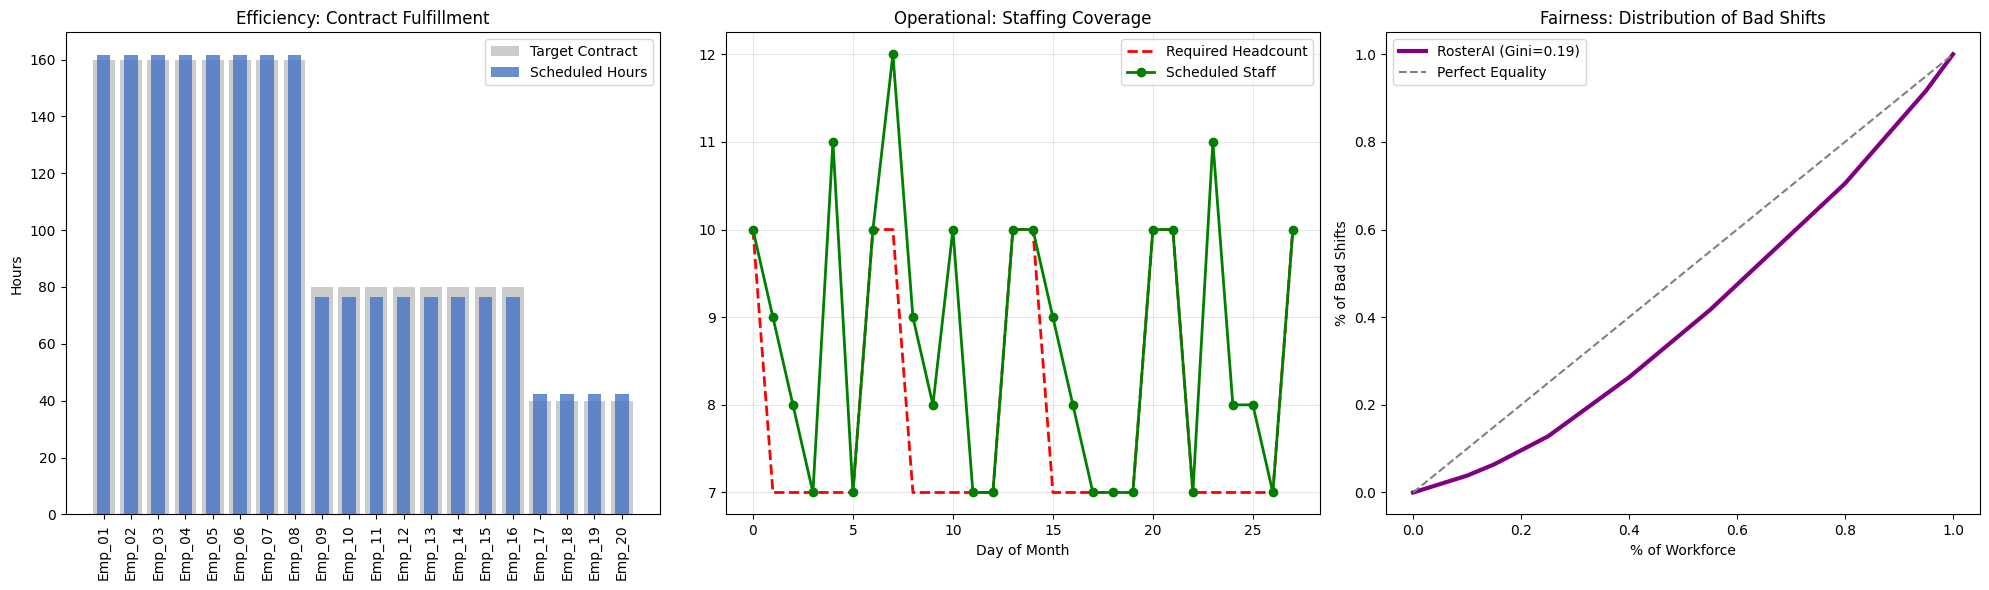


✅ Report Generated: 'Monthly_Schedule.xlsx'
   - Sheet 1: Editable Roster (with Dates)
   - Sheet 2: Fairness Metrics & Stats


In [19]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.styles import PatternFill, Font, Alignment, Border, Side

# --- Configuration ---
SCALE = 2  # 17 units = 8.5 hours. We divide by this to get real hours.

def load_data():
    try:
        with open('sample.json', 'r') as f:
            config = json.load(f)
        with open('logic.json', 'r') as f:
            logic = json.load(f)
        return config, logic
    except FileNotFoundError:
        return None, None

def xAI_engine(df, employees, shifts, num_days):
    """Calculates Fairness (Gini), Efficiency, and explains the results."""

    # 1. Real Hours Calculation (Un-scaling the data)
    # We map the shift code to its duration (e.g., 'E' -> 8.5)
    df['Hours_Real'] = df['Shift'].apply(lambda x: shifts[x]['duration'])

    stats = df.groupby('Employee')['Hours_Real'].sum().reset_index()

    # Map Targets
    emp_map = {e['id']: e['contract'] for e in employees}
    stats['Target'] = stats['Employee'].map(lambda x: emp_map[x]['target'])
    stats['Diff'] = stats['Hours_Real'] - stats['Target']

    # 2. Gini Coefficient (Fairness of Bad Shifts)
    # Identify bad shifts (Undesirable OR Weekend)
    def is_bad(row):
        # Approximate weekend calculation based on Day Index
        is_weekend = (int(row['Day']) % 7) >= 5
        return 1 if (shifts[row['Shift']]['undesirable'] or is_weekend) else 0

    df['Is_Bad'] = df.apply(is_bad, axis=1)
    bad_counts = df.groupby('Employee')['Is_Bad'].sum().values

    # Gini Math
    sorted_vals = sorted(bad_counts)
    n = len(sorted_vals)
    cum_vals = np.cumsum(sorted_vals)
    sum_vals = cum_vals[-1]
    gini = (n + 1 - 2 * np.sum(cum_vals) / sum_vals) / n if sum_vals > 0 else 0

    return stats, gini, df

def plot_dashboard(stats, df, demand, days_range, gini):
    """Generates the 3 key plots for the Thesis."""
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # Plot 1: Efficiency (Target vs Actual)
    axes[0].bar(stats['Employee'], stats['Target'], alpha=0.4, label='Target Contract', color='gray')
    axes[0].bar(stats['Employee'], stats['Hours_Real'], alpha=0.8, label='Scheduled Hours', color='#4472C4', width=0.5)
    axes[0].set_title("Efficiency: Contract Fulfillment")
    axes[0].tick_params(axis='x', rotation=90)
    axes[0].set_ylabel("Hours")
    axes[0].legend()

    # Plot 2: Coverage (Demand vs Supply)
    daily_counts = df.groupby('Day')['Shift'].count().reindex(days_range, fill_value=0)
    # Demand is a dict of dicts {day: {shift: count}}. Sum values for total headcount.
    req_counts = [sum(demand[str(d)].values()) for d in days_range]

    axes[1].plot(days_range, req_counts, 'r--', linewidth=2, label='Required Headcount')
    axes[1].plot(days_range, daily_counts.values, 'g-', linewidth=2, marker='o', label='Scheduled Staff')
    axes[1].set_title("Operational: Staffing Coverage")
    axes[1].set_xlabel("Day of Month")
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()

    # Plot 3: Fairness (Lorenz Curve)
    bad_counts = df.groupby('Employee')['Is_Bad'].sum().sort_values().values
    lorenz = np.cumsum(bad_counts) / np.sum(bad_counts)
    lorenz = np.insert(lorenz, 0, 0)
    x_axis = np.linspace(0, 1, len(lorenz))

    axes[2].plot(x_axis, lorenz, color='purple', linewidth=3, label=f'RosterAI (Gini={gini:.2f})')
    axes[2].plot([0, 1], [0, 1], color='gray', linestyle='--', label='Perfect Equality')
    axes[2].set_title("Fairness: Distribution of Bad Shifts")
    axes[2].set_xlabel("% of Workforce")
    axes[2].set_ylabel("% of Bad Shifts")
    axes[2].legend()

    plt.tight_layout()
    plt.show()

def generate_report():
    config, logic = load_data()
    if not config or not logic or not logic['schedule']:
        print("❌ No data found. Run Blocks 1 & 2.")
        return

    # 1. Prepare Data
    df = pd.DataFrame(logic['schedule'])
    days_range = range(config['config']['DAYS'])

    # 2. Run Analytics
    print("🧠 Analyzing Schedule...")
    stats, gini, df_enriched = xAI_engine(df, config['employees'], config['config']['SHIFTS'], config['config']['DAYS'])

    # 3. Show Plots (The Visuals you wanted)
    plot_dashboard(stats, df_enriched, config['demand'], days_range, gini)

    # 4. Generate User-Friendly Excel
    wb = Workbook()

    # -- SHEET 1: The Editable Schedule --
    ws = wb.active
    ws.title = "Schedule_Edit_Here"

    # Create Date Headers (Feb 01 Sun, etc.)
    start_date = datetime.strptime(config['config']['START_DATE'], "%Y-%m-%d")
    date_headers = []
    for d in days_range:
        current = start_date + timedelta(days=d)
        date_headers.append(current.strftime("%b %d\n%a"))

    # Pivot Data
    grid = df.pivot(index='Employee', columns='Day', values='Shift').fillna('')
    grid = grid.reindex(columns=days_range, fill_value="")

    # Write to Excel
    ws.append(["Employee"] + date_headers) # Header Row
    for emp_id, row in grid.iterrows():
        ws.append([emp_id] + row.tolist())

    # Styles
    header_fill = PatternFill(start_color="4472C4", fill_type="solid")
    header_font = Font(bold=True, color="FFFFFF")
    center = Alignment(horizontal='center', vertical='center', wrap_text=True)
    border = Border(left=Side(style='thin'), right=Side(style='thin'), top=Side(style='thin'), bottom=Side(style='thin'))

    shift_colors = {'E': "FFEB3B", 'D': "98FB98", 'L': "FF6B6B"} # Yellow, Green, Red

    # Apply Styles
    for cell in ws[1]: # Header
        cell.fill = header_fill
        cell.font = header_font
        cell.alignment = center

    for row in ws.iter_rows(min_row=2):
        for cell in row:
            cell.alignment = center
            cell.border = border
            if cell.value in shift_colors:
                cell.fill = PatternFill(start_color=shift_colors[cell.value], fill_type='solid')

    # -- SHEET 2: Manager Dashboard (The Metrics you wanted) --
    ws_dash = wb.create_sheet("Manager_Dashboard")
    ws_dash.append(["Metric", "Value", "Note"])
    ws_dash.append(["Gini Coefficient", f"{gini:.3f}", "Target < 0.15"])
    ws_dash.append(["Total Hours", f"{stats['Hours_Real'].sum()}", ""])
    ws_dash.append([])

    ws_dash.append(["Employee", "Target", "Actual", "Difference"])
    for _, row in stats.iterrows():
        ws_dash.append([row['Employee'], row['Target'], row['Hours_Real'], row['Diff']])

    # Save
    wb.save('Monthly_Schedule.xlsx')
    print(f"\n✅ Report Generated: 'Monthly_Schedule.xlsx'")
    print(f"   - Sheet 1: Editable Roster (with Dates)")
    print(f"   - Sheet 2: Fairness Metrics & Stats")

generate_report()

🎓 Block 4: The Feedback Loop (The Apprentice)
Input: Monthly_Schedule.xlsx (Edited by Manager) | Output: Updates sample.json

This is where RosterAI distinguishes itself from standard software. It assumes the Manager knows best.

How it works:

You Edit: You open the Excel file generated in Block 3. You realize "Emp_05" hates working Mondays, so you manually change their shift or delete it. You save the file.

It Learns: You run Block 4. The system reads your Excel file. It notices where you placed people manually.

It Remembers: It updates the "Learned Weights" in the system configuration. It assigns a high "reward" points to the shifts you manually confirmed.

Next Time: When you run Block 2 (Logic) again, the AI will fight to keep those assignments exactly where you put them, treating your preference as a high-priority rule.

The Result: The more you use it, the more the AI mimics your management style.

In [20]:
import pandas as pd
import json
import os

def run_feedback():
    print("🧠 Reading Manager Feedback...")

    try:
        with open('sample.json', 'r') as f:
            data = json.load(f)
    except:
        print("❌ sample.json not found.")
        return

    file_path = 'Monthly_Schedule.xlsx'
    if not os.path.exists(file_path):
        print("❌ Excel file not found.")
        return

    # Load Excel (Index=Col 0, Header=Row 0)
    try:
        df = pd.read_excel(file_path, sheet_name='Schedule_Edit_Here', index_col=0)
        df = df.fillna('')
    except Exception as e:
        print(f"❌ Error reading Excel: {e}")
        return

    weights = data.get('learned_weights', {})
    count = 0

    # Iterate by Index (Employees) and Position (Days 0..N)
    for emp_id in df.index:
        emp_id = str(emp_id)
        if emp_id not in weights: weights[emp_id] = {}

        for i in range(len(df.columns)):
            # Cell value at (Employee, Day_Index)
            shift = str(df.iloc[df.index.get_loc(emp_id), i]).strip()
            day_idx = str(i)

            if shift in ['E', 'D', 'L']:
                if day_idx not in weights[emp_id]: weights[emp_id][day_idx] = {}

                # Boost weight
                curr = weights[emp_id][day_idx].get(shift, 0)
                weights[emp_id][day_idx][shift] = min(curr + 100, 1000)
                count += 1

    data['learned_weights'] = weights
    with open('sample.json', 'w') as f:
        json.dump(data, f, indent=4)

    print(f"✅ Learned from {count} shifts. Run Block 2 to apply changes.")

run_feedback()

🧠 Reading Manager Feedback...
✅ Learned from 244 shifts. Run Block 2 to apply changes.
